In [1]:
import os
import numpy as np
import pandas as pd
from aisynphys.cell_class import CellClass
from aisynphys.ui.notebook import cell_class_matrix, ei_hist_plot, plot_metric_pairs, metric_stats, pair_class_metric_scatter, compose_svg_figure
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, mood, ks_2samp
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Arial"

db = SynphysDatabase.load_current('small')
print(db.schema_version)

21


In [11]:
def mann_whitney_test(data, subclass1, subclass2, metric, args={}):
    pre1, post1 = subclass1
    if type(pre1) is list and type(post1) is list:
        data1 = data[(data['pre_class'].isin(pre1)) & (data['post_class'].isin(post1))][metric].to_numpy()
    else:
        data1 = data[(data['pre_class']==pre1) & (data['post_class']==post1)][metric].to_numpy()
    pre2, post2 = subclass2
    if type(pre2) is list and type(post2) is list:
        data2 = data[(data['pre_class'].isin(pre2)) & (data['post_class'].isin(post2))][metric].to_numpy()
    else:
        data2 = data[(data['pre_class']==pre2) & (data['post_class']==post2)][metric].to_numpy()
    
    mw_stat, mw_pval = mannwhitneyu(data1, data2, **args)
    ks_stat, ks_pval = ks_2samp(data1, data2)
    
    print('%s -> %s %s median: %0.2e [%0.2e, %0.2e]' % (pre1, post1, metric, np.median(data1), np.percentile(data1, 25), np.percentile(data1, 75)))
    print('%s -> %s %s median: %0.2e [%0.2e, %0.2e]' % (pre2, post2, metric, np.median(data2), np.percentile(data2, 25), np.percentile(data2, 75)))
    print('Mann Whitney p-val: %0.2e' % mw_pval)
#     print('KS p-val: %0.2e' % ks_pval)
    
    return mw_pval

### Create cell classes defined by transgenic reporter

In [3]:
cell_class_criteria = {
    'l23pyr': {'cell_class': 'ex', 'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'), 'cell_class': 'ex'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cell_class': 'ex'},
    'l5it':   {'cre_type': 'tlx3', 'cell_class': 'ex'}, 
    'l6pyr':  {'cre_type': 'ntsr1', 'cell_class': 'ex'},
    'pv':     {'cre_type': 'pvalb', 'cell_class': 'in'},
    'sst':    {'cre_type': 'sst', 'cell_class': 'in'},
    'vip':    {'cre_type': 'vip', 'cell_class': 'in'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}
ei_classes = {'ex': CellClass(cell_class='ex'), 'in': CellClass(cell_class='in')}

class_labels = {
    'l23pyr': 'L2/3 Pyr\n spiny',
    'l4pyr':  'L4 Pyr\n nr5a1',
    'l5et':   'L5 ET\n sim1, mscRE4',
    'l5it':   'L5 IT\n tlx3', 
    'l6pyr':  'L6 Pyr\n ntsr1',
    'pv':     'Pv',
    'sst':    'Sst',
    'vip':    'Vip',
}

pair_query_args = {
    'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
    'synapse': True,
}

### A) Latency of postsynaptic responses among cell classes

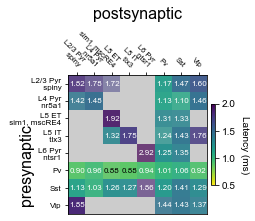

In [4]:
latency_fig, ax = plt.subplots(figsize=(3,3))

latency_df = cell_class_matrix(cell_classes, cell_classes, 'latency', class_labels, ax, db, pair_query_args=pair_query_args, 
                               estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=7.5)
_ = plt.setp(ax.get_yticklabels(), fontsize=8)
ax.yaxis.set_label_coords(-0.25, 0.35)

In [4]:
latency_df.groupby(['pre_class', 'post_class']).describe()['latency']

count      mean       std       min       25%       50%  \
pre_class post_class                                                            
l23pyr    l23pyr       15.0  0.001957  0.000674  0.001118  0.001604  0.001824   
          l4pyr         4.0  0.001820  0.000743  0.001067  0.001272  0.001778   
          l5et          2.0  0.001724  0.000981  0.001030  0.001377  0.001724   
          pv           30.0  0.001262  0.000429  0.000742  0.000917  0.001166   
          sst          30.0  0.001517  0.000458  0.000856  0.001161  0.001474   
          vip          12.0  0.001613  0.000309  0.001209  0.001316  0.001605   
l4pyr     l23pyr        7.0  0.001693  0.000491  0.001340  0.001404  0.001422   
          l4pyr        63.0  0.001608  0.000555  0.000696  0.001228  0.001479   
          pv           16.0  0.001144  0.000383  0.000728  0.000807  0.001129   
          sst           5.0  0.001343  0.000472  0.000856  0.001070  0.001100   
          vip           3.0  0.001481  0.000132  0.001361  0.001411  0.001461   
l5et      l5et         78.0  0.002075  0.000903  0.000893  0.001501  0.001921   
          pv            4.0  0.001282  0.000323  0.000874  0.001125  0.001311   
          sst           7.0  0.001503  0.000488  0.000992  0.001132  0.001326   
l5it      l5et          6.0  0.001374  0.000362  0.001014  0.001092  0.001320   
          l5it         45.0  0.001734  0.000554  0.000429  0.001468  0.001753   
          pv           25.0  0.001705  0.001307  0.000862  0.001072  0.001242   
          sst          29.0  0.001474  0.000360  0.000872  0.001217  0.001431   
          vip           5.0  0.001650  0.000447  0.001002  0.001406  0.001758   
l6pyr     l6pyr         2.0  0.002922  0.000616  0.002486  0.002704  0.002922   
          pv           12.0  0.001197  0.000194  0.000804  0.001082  0.001253   
          sst           7.0  0.001366  0.000281  0.000946  0.001275  0.001345   
pv        l23pyr       27.0  0.000956  0.000297  0.000477  0.000722  0.000902   
          l4pyr        23.0  0.001049  0.000431  0.000488  0.000685  0.000964   
          l5et         14.0  0.001050  0.000508  0.000441  0.000781  0.000878   
          l5it         29.0  0.000908  0.000188  0.000599  0.000764  0.000881   
          l6pyr        16.0  0.000984  0.000236  0.000679  0.000864  0.000937   
          pv          262.0  0.001055  0.000333  0.000508  0.000837  0.001008   
          sst          15.0  0.001013  0.000331  0.000500  0.000795  0.001055   
          vip          10.0  0.000866  0.000300  0.000408  0.000623  0.000920   
sst       l23pyr       22.0  0.001125  0.000305  0.000530  0.000949  0.001134   
          l4pyr        16.0  0.001143  0.000430  0.000560  0.000861  0.001033   
          l5et         16.0  0.001261  0.000300  0.000714  0.001109  0.001261   
          l5it         19.0  0.001442  0.000508  0.000783  0.001075  0.001274   
          l6pyr         4.0  0.002032  0.000894  0.001261  0.001336  0.001859   
          pv           58.0  0.001346  0.000475  0.000532  0.001000  0.001199   
          sst          44.0  0.001526  0.000528  0.000626  0.001166  0.001412   
          vip          51.0  0.001361  0.000600  0.000455  0.000954  0.001291   
vip       l23pyr        2.0  0.001846  0.000040  0.001818  0.001832  0.001846   
          l4pyr         1.0  0.002639       NaN  0.002639  0.002639  0.002639   
          l6pyr         1.0  0.001494       NaN  0.001494  0.001494  0.001494   
          pv           11.0  0.001446  0.000651  0.000434  0.001070  0.001438   
          sst          34.0  0.001496  0.000510  0.000097  0.001151  0.001425   
          vip          13.0  0.001551  0.000543  0.001050  0.001206  0.001368   

                           75%       max  
pre_class post_class                      
l23pyr    l23pyr      0.002135  0.003847  
          l4pyr       0.002326  0.002657  
          l5et        0.002071  0.002418  
          pv          0.001464  0.002455  
          sst         0.001746  0.002

Two-sample KS test for latency
Excitatory: p = 5.774e-10
Inhibitory: p = 5.481e-03


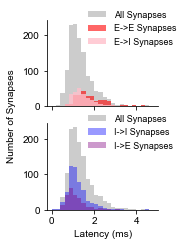

In [5]:
bin_edges = np.arange(0, 5, 0.2)

latency_hist, ax_latency = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(2, 3.5))
ex_latency, in_latency = ei_hist_plot(ax_latency, 'latency', bin_edges, db, pair_query_args)
ax_latency[1].set_ylabel('')
latency_hist.text(-0.15, 0.5, 'Number of Synapses', va='center', rotation='vertical', fontsize=10)

ax_latency[0].legend(loc='upper left', bbox_to_anchor=(0.3, 1.2), frameon=False, prop={'size':9})
ax_latency[1].legend(loc='upper left', bbox_to_anchor=(0.3, 1.2), frameon=False, prop={'size':9})

In [6]:
from scipy import stats
print(ex_latency.describe()['latency'])
print(in_latency.describe()['latency'])
stats.ks_2samp(ex_latency['latency'], in_latency['latency'])

count    489.000000
mean       0.001666
std        0.000796
min       -0.000044
25%        0.001186
50%        0.001485
75%        0.001925
max        0.007275
Name: latency, dtype: float64
count    778.000000
mean       0.001184
std        0.000493
min        0.000097
25%        0.000867
50%        0.001071
75%        0.001386
max        0.004965
Name: latency, dtype: float64


Ks_2sampResult(statistic=0.3618081074119051, pvalue=1.4438399968405775e-34)

In [7]:
latency, units = metric_stats('latency', db, pre_classes=ei_classes, post_classes=ei_classes, pair_query_args=pair_query_args)
print('Units: %s' % units)
latency

Units: ms


count      mean       std       min       25%       50%  \
pre_class post_class                                                            
ex        ex          252.0  1.833797  0.776155  0.397223  1.326044  1.668565   
          in          237.0  1.487490  0.779361 -0.043630  1.104165  1.338332   
in        ex          240.0  1.126941  0.499968  0.440790  0.819093  1.004552   
          in          538.0  1.209332  0.487743  0.097360  0.900091  1.099758   

                           75%       max  
pre_class post_class                      
ex        ex          2.238544  6.597696  
          in          1.673363  7.274845  
in        ex          1.309547  4.965393  
          in          1.416342  4.502295

[None, None]

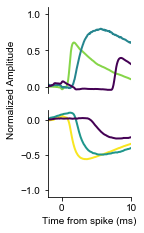

In [8]:
latency_traces, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5, 3.5))

label =     ['L6pyr->pv',                  'L4pyr->L4pyr',                'L5IT->pv']
latency_e = [('1555537426.202', '1', '6'), ('1521236933.206', '8', '5'), ('1537396098.212', '6', '7')]
plot_metric_pairs(latency_e, 'latency', db, ax[0], align='spike', norm_amp='exc', labels=label)
ax[0].set_ylim(None, 1.1)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.xaxis.set_visible(False)

label =     ['pv->pv',                       'pv->L4pyr',                'sst->L5ET']
latency_i = [('1509479984.260', '7', '6'), ('1555539125.582', '5', '2'), ('1545430290.609', '8', '2')]
plot_metric_pairs(latency_i, 'latency', db, ax[1], align='spike', norm_amp='inh', labels=label)
ax[1].set_ylim(-1.1, None)
ax[1].set_xlabel('Time from spike (ms)')
ax[1].set_ylabel('Normalized amplitude')

ax[1].set_ylabel('')
latency_traces.text(-0.25, 0.55, 'Normalized Amplitude', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax]

### B) Rise Tau

Text(0.5, 0, '')

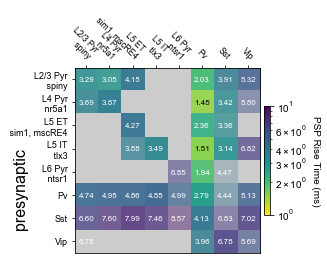

In [34]:
rise_fig, ax = plt.subplots(figsize=(4,4))

rise_df = cell_class_matrix(cell_classes, cell_classes, 'psp_rise_time', class_labels, ax, db, pair_query_args=pair_query_args,
                           estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8.5)
_ = plt.setp(ax.get_yticklabels(), fontsize=9)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [10]:
rise_df = rise_df.astype({'psp_rise_time': float})
rise_df.groupby(['pre_class', 'post_class']).describe()['psp_rise_time']

count      mean       std       min       25%       50%  \
pre_class post_class                                                            
l23pyr    l23pyr       17.0  0.003591  0.001578  0.001251  0.002335  0.003288   
          l4pyr         4.0  0.002777  0.000952  0.001487  0.002343  0.003054   
          l5et          2.0  0.004152  0.000392  0.003875  0.004014  0.004152   
          pv           27.0  0.002075  0.000934  0.001004  0.001214  0.002034   
          sst          28.0  0.004138  0.002323  0.001692  0.002690  0.003907   
          vip          10.0  0.005085  0.001501  0.002042  0.004692  0.005321   
l4pyr     l23pyr        6.0  0.003450  0.001163  0.001251  0.003488  0.003686   
          l4pyr        57.0  0.004039  0.001392  0.001487  0.003190  0.003865   
          pv           14.0  0.001827  0.000977  0.001004  0.001275  0.001454   
          sst           4.0  0.003177  0.001095  0.001735  0.002631  0.003416   
          vip           2.0  0.005799  0.002168  0.004265  0.005032  0.005799   
l5et      l5et         83.0  0.004583  0.002038  0.001608  0.002966  0.004265   
          pv            4.0  0.002459  0.000733  0.001673  0.002180  0.002359   
          sst           8.0  0.004190  0.001890  0.002849  0.003009  0.003357   
l5it      l5et          5.0  0.004265  0.001511  0.002831  0.003254  0.003875   
          l5it         50.0  0.003868  0.001358  0.001934  0.002986  0.003493   
          pv           23.0  0.001754  0.000622  0.000916  0.001329  0.001514   
          sst          31.0  0.003514  0.001595  0.001119  0.002571  0.003139   
          vip           4.0  0.007020  0.001636  0.005237  0.006385  0.006820   
l6pyr     l6pyr         3.0  0.006053  0.002043  0.003732  0.005289  0.006846   
          pv            7.0  0.001793  0.000680  0.000755  0.001375  0.001939   
          sst           6.0  0.005661  0.004105  0.001980  0.003898  0.004465   
pv        l23pyr       26.0  0.005156  0.001690  0.002968  0.004205  0.004736   
          l4pyr        21.0  0.005442  0.001544  0.002761  0.004528  0.004952   
          l5et         12.0  0.004831  0.001157  0.002941  0.004145  0.004850   
          l5it         29.0  0.005049  0.001169  0.002802  0.004386  0.004852   
          l6pyr        10.0  0.005392  0.002248  0.002648  0.004175  0.004989   
          pv          256.0  0.003126  0.001569  0.000878  0.002275  0.002788   
          sst          18.0  0.006422  0.004991  0.001752  0.003401  0.004442   
          vip           9.0  0.004977  0.001546  0.002743  0.003632  0.005125   
sst       l23pyr       24.0  0.007456  0.002769  0.003118  0.005853  0.006601   
          l4pyr        15.0  0.007773  0.002640  0.004210  0.005561  0.007595   
          l5et         13.0  0.007784  0.001696  0.004964  0.007036  0.007991   
          l5it         19.0  0.007588  0.002511  0.003991  0.005509  0.007461   
          l6pyr         4.0  0.008793  0.002506  0.006075  0.007334  0.008569   
          pv           64.0  0.004300  0.001285  0.001271  0.003459  0.004127   
          sst          46.0  0.008221  0.007016  0.002294  0.004537  0.006825   
          vip          51.0  0.007885  0.003196  0.001893  0.005651  0.007024   
vip       l23pyr        2.0  0.006778  0.004291  0.003744  0.005261  0.006778   
          pv           11.0  0.004393  0.001434  0.003181  0.003566  0.003960   
          sst          32.0  0.006765  0.002110  0.003088  0.004989  0.006782   
          vip          11.0  0.007016  0.002784  0.004531  0.005431  0.005694   

                           75%       max  
pre_class post_class                      
l23pyr    l23pyr      0.004183  0.006604  
          l4pyr       0.003488  0.003513  
          l5et        0.004291  0.004429  
          pv          0.002657  0.004086  
          sst         0.004788  0.012049  
          vip         0.005592  0.007848  
l4pyr     l23pyr      0.003890  0.004695  
          l4pyr       0.004587  0.009225  
          pv          0.001

In [68]:
sst_vip_l5it = mann_whitney_test(rise_df, ('sst', 'vip'), ('sst', 'l5it'), 'psp_rise_time')

e_pv_sst = mann_whitney_test(rise_df, ('l4pyr', 'pv'), ('l23pyr', 'sst'), 'psp_rise_time')


sst -> vip psp_rise_time median: 7.02e-03
sst -> l5it psp_rise_time median: 7.46e-03
Mann Whitney p-val: 4.16e-01
l4pyr -> pv psp_rise_time median: 1.45e-03
l23pyr -> sst psp_rise_time median: 3.91e-03
Mann Whitney p-val: 1.88e-05


Two-sample KS test for psp_rise_time
Excitatory: p = 2.972e-12
Inhibitory: p = 5.551e-16


[None, None]

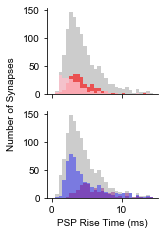

In [11]:
bin_edges = np.arange(0, 15, 0.5)

rise_hist, ax_rt = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(2,3.5))
_, _ = ei_hist_plot(ax_rt, 'psp_rise_time', bin_edges, db, pair_query_args)
ax_rt[1].set_ylabel('')
rise_hist.text(-0.15, 0.5, 'Number of Synapses', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax_rt]

In [12]:
rise_tau, units = metric_stats('psp_rise_time', db, pre_classes=ei_classes, post_classes=ei_classes, pair_query_args=pair_query_args)
print('Units: %s' % units)
rise_tau

Units: ms


count      mean       std       min       25%       50%  \
pre_class post_class                                                            
ex        ex          255.0  4.228891  1.752213  0.530207  3.009935  3.880174   
          in          213.0  3.170908  1.971130  0.755350  1.720041  2.747133   
in        ex          215.0  6.237319  2.615530  2.346430  4.484438  5.535749   
          in          547.0  4.809550  3.678431  0.877649  2.693306  3.650965   

                           75%        max  
pre_class post_class                       
ex        ex          5.174110  13.150219  
          in          3.912053  13.668822  
in        ex          7.461541  19.766875  
          in          5.698326  49.553641

[None, None]

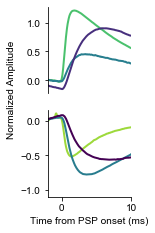

In [13]:
rise_traces, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5, 3.5))
                                
label =  ['L6pyr->pv',                    'L5IT->L5IT',                 'L4pyr->vip']                      
rise_e = [('1522259564.089', '4', '2'), ('1532379596.694', '6', '2'), ('1561758694.448', '7', '2')]
plot_metric_pairs(rise_e, 'psp_rise_time', db, ax[0], align='pulse', norm_amp='exc', labels=label)
# ax[0].set_ylim(None, 1.1)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.xaxis.set_visible(False)

label =  ['pv->pv',                          'sst->pv',                'sst->vip']
rise_i = [('1530559621.966', '7', '6') , ('1565644294.682', '1', '4'), ('1540849442.801', '7', '1')]
plot_metric_pairs(rise_i, 'psp_rise_time', db, ax[1], align='pulse', norm_amp='inh', labels=label)
ax[1].set_ylim(-1.1, None)
ax[1].set_xlabel('Time from PSP onset (ms)')
ax[1].set_ylabel('Normalized amplitude')

ax[1].set_ylabel('')
rise_traces.text(-0.25, 0.55, 'Normalized Amplitude', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax]

### C) PSP Decay Tau among cell classes

Text(0.5, 0, '')

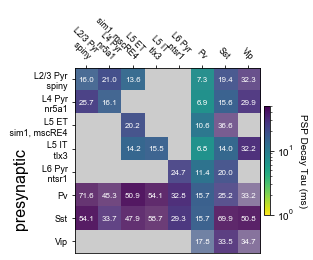

In [39]:
decay_fig, ax = plt.subplots(figsize=(4,4))

decay_query_args = pair_query_args.copy()
decay_query_args.update({'filter_exprs': [db.Synapse.psp_decay_tau < 0.49]})
decay_df = cell_class_matrix(cell_classes, cell_classes, 'psp_decay_tau', class_labels, ax, db, pair_query_args=decay_query_args,
                            estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8.5)
_ = plt.setp(ax.get_yticklabels(), fontsize=9)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [15]:
decay_df = decay_df.astype({'psp_decay_tau': float})
decay_df.groupby(['pre_class', 'post_class']).describe()['psp_decay_tau']

count      mean       std       min       25%       50%  \
pre_class post_class                                                            
l23pyr    l23pyr       16.0  0.033547  0.058462  0.005842  0.011683  0.016044   
          l4pyr         4.0  0.022254  0.011159  0.011967  0.013417  0.020995   
          l5et          2.0  0.013562  0.012098  0.005008  0.009285  0.013562   
          pv           27.0  0.014773  0.021960  0.005000  0.005666  0.007261   
          sst          27.0  0.032368  0.055499  0.006050  0.014884  0.019409   
          vip          10.0  0.061772  0.083806  0.018081  0.028832  0.032285   
l4pyr     l23pyr        6.0  0.026889  0.016378  0.009418  0.013071  0.025720   
          l4pyr        55.0  0.040022  0.074164  0.005000  0.011221  0.016051   
          pv           14.0  0.008243  0.004474  0.005000  0.005400  0.006915   
          sst           4.0  0.017122  0.010480  0.006050  0.012192  0.015613   
          vip           2.0  0.029854  0.019898  0.015784  0.022819  0.029854   
l5et      l5et         83.0  0.037860  0.061510  0.005000  0.012020  0.020156   
          pv            4.0  0.010224  0.004251  0.005000  0.007867  0.010564   
          sst           8.0  0.082483  0.111239  0.007426  0.013193  0.036600   
l5it      l5et          4.0  0.013882  0.007119  0.005000  0.010704  0.014206   
          l5it         49.0  0.028074  0.045924  0.005000  0.009850  0.015511   
          pv           23.0  0.007681  0.003482  0.005000  0.005409  0.006809   
          sst          31.0  0.019918  0.014508  0.005000  0.010610  0.014034   
          vip           4.0  0.032081  0.014436  0.016648  0.021693  0.032185   
l6pyr     l6pyr         3.0  0.029518  0.022899  0.009396  0.017059  0.024722   
          pv            7.0  0.009971  0.003351  0.005931  0.006861  0.011431   
          sst           6.0  0.027816  0.024444  0.007655  0.011572  0.019997   
pv        l23pyr       21.0  0.103810  0.118581  0.007346  0.040513  0.071641   
          l4pyr        20.0  0.109560  0.146300  0.006041  0.026458  0.045276   
          l5et         11.0  0.059002  0.037535  0.022800  0.037346  0.050908   
          l5it         29.0  0.103864  0.113700  0.016667  0.036542  0.054064   
          l6pyr        10.0  0.035939  0.019307  0.005000  0.024148  0.032783   
          pv          251.0  0.031694  0.056566  0.005000  0.010137  0.015671   
          sst          17.0  0.060846  0.070730  0.006983  0.013759  0.025210   
          vip           9.0  0.118415  0.167067  0.014683  0.019399  0.033178   
sst       l23pyr       24.0  0.074214  0.066598  0.007733  0.032001  0.054099   
          l4pyr        15.0  0.062357  0.078023  0.006317  0.019448  0.033735   
          l5et         13.0  0.076067  0.082658  0.005576  0.022549  0.047947   
          l5it         18.0  0.111559  0.129138  0.008287  0.027756  0.058686   
          l6pyr         4.0  0.029319  0.012441  0.014274  0.023701  0.029331   
          pv           64.0  0.028039  0.042343  0.005000  0.010805  0.015682   
          sst          45.0  0.120868  0.127948  0.005711  0.030904  0.069945   
          vip          46.0  0.101492  0.111038  0.005577  0.026965  0.050807   
vip       l23pyr        1.0  0.022390       NaN  0.022390  0.022390  0.022390   
          pv           11.0  0.077979  0.132579  0.005000  0.012687  0.017806   
          sst          31.0  0.061699  0.086688  0.012322  0.022260  0.033536   
          vip           9.0  0.114091  0.153144  0.008948  0.023761  0.034713   

                           75%       max  
pre_class post_class                      
l23pyr    l23pyr      0.030246  0.249245  
          l4pyr       0.029832  0.035057  
          l5et        0.017840  0.022117  
          pv          0.011935  0.092941  
          sst         0.028482  0.304767  
          vip         0.041620  0.296102  
l4pyr     l23pyr      0.038908  0.048318  
          l4pyr       0.029009  0.473454  
          pv          0.008

In [69]:
sst_vip_l5it = mann_whitney_test(decay_df, ('sst', 'vip'), ('sst', 'l5it'), 'psp_decay_tau')

e_pv_sst = mann_whitney_test(decay_df, ('l4pyr', 'pv'), ('l23pyr', 'sst'), 'psp_decay_tau')


sst -> vip psp_decay_tau median: 5.08e-02
sst -> l5it psp_decay_tau median: 5.87e-02
Mann Whitney p-val: 4.20e-01
l4pyr -> pv psp_decay_tau median: 6.92e-03
l23pyr -> sst psp_decay_tau median: 1.94e-02
Mann Whitney p-val: 1.22e-05


Two-sample KS test for psp_decay_tau
Excitatory: p = 2.447e-07
Inhibitory: p = 1.110e-15


[None, None]

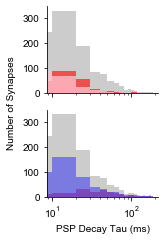

In [16]:
bin_edges = np.arange(0, 200, 10)

decay_hist, ax_decay = plt.subplots(2, 1, sharey=True, sharex=False, figsize=(2, 3.5))
ei_hist_plot(ax_decay, 'psp_decay_tau', bin_edges, db, pair_query_args=decay_query_args)
ax_decay[0].set_xscale('log')
ax_decay[1].set_xscale('log')
ax_decay[1].set_ylabel('')
ax_decay[0].tick_params(labelbottom=False)
decay_hist.text(-0.15, 0.5, 'Number of Synapses', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax_decay]

In [17]:
psp_decay, units = metric_stats('psp_decay_tau', db, pre_classes=ei_classes, post_classes=ei_classes, pair_query_args=decay_query_args)
print('Units: %s' % units)
psp_decay

Units: ms


count       mean         std  min        25%        50%  \
pre_class post_class                                                            
ex        ex          250.0  34.181816   56.773996  5.0  11.354504  17.223194   
          in          212.0  22.819033   41.869848  5.0   7.142095  12.216264   
in        ex          206.0  92.891605  109.153497  5.0  26.840766  50.296687   
          in          529.0  52.683363   86.799375  5.0  11.563762  20.741547   

                            75%         max  
pre_class post_class                         
ex        ex          29.087639  473.454239  
          in          21.275411  325.296946  
in        ex          96.119905  487.462982  
          in          46.196292  479.127353

[None, None]

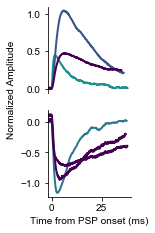

In [18]:
decay_traces, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5, 3.5))

label =    ['L5ET->L5ET',                'L2/3pyr->vip',                 'L5IT->pv']                      
decay_e =  [('1510784600.164', '2', '4'), ('1528924710.559', '2', '5'), ('1530900438.580', '1','6')]
plot_metric_pairs(decay_e, 'psp_decay_tau', db, ax[0], align='pulse', norm_amp='exc', max_ind_freq=20, labels=label)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.xaxis.set_visible(False)
ax[0].set_xlim(-2, 40)

label =   ['sst->pv',                     'sst->sst',                     'pv->L2/3pyr']
decay_i = [('1565734002.873', '5', '3'), ('1499890136.257', '7', '5'), ('1530304502.023', '6', '3')]
plot_metric_pairs(decay_i, 'psp_decay_tau', db, ax[1], align='pulse', norm_amp='inh', max_ind_freq=20, labels=label)
ax[1].set_xlabel('Time from PSP onset (ms)')
ax[1].set_ylabel('Normalized Amplitude')
ax[0].set_xlim(-2, 40)

ax[1].set_ylabel('')
decay_traces.text(-0.25, 0.55, 'Normalized Amplitude', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax]

### D) Resting state amplitude of postsynaptic responses among cell classes

Text(0.5, 0, '')

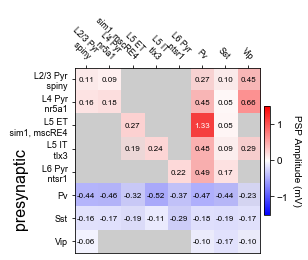

In [4]:
resting_state_fig, ax = plt.subplots(figsize=(4,4))

rs_df = cell_class_matrix(cell_classes, cell_classes, 'psp_amplitude', class_labels, ax, db, pair_query_args=pair_query_args,
                         estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8.5)
_ = plt.setp(ax.get_yticklabels(), fontsize=9)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [20]:
rs_df = rs_df.astype({'psp_amplitude': float})
rs_df.groupby(['pre_class', 'post_class']).describe()['psp_amplitude']

count      mean       std           min       25%  \
pre_class post_class                                                      
l23pyr    l23pyr       13.0  0.000263  0.000273  3.118241e-05  0.000071   
          l4pyr         3.0  0.000101  0.000027  8.123576e-05  0.000086   
          l5et          1.0  0.000147       NaN  1.467555e-04  0.000147   
          pv           25.0  0.000552  0.000771  6.394223e-05  0.000188   
          sst          26.0  0.000293  0.000455  1.009704e-07  0.000060   
          vip           9.0  0.000601  0.000479  1.079984e-04  0.000263   
l4pyr     l23pyr        6.0  0.000160  0.000073  8.123576e-05  0.000105   
          l4pyr        55.0  0.000344  0.000361  4.812801e-05  0.000109   
          pv           14.0  0.000552  0.000449  7.402976e-05  0.000210   
          sst           4.0  0.000038  0.000028  4.445098e-07  0.000024   
          vip           2.0  0.000662  0.000105  5.872571e-04  0.000624   
l5et      l5et         69.0  0.000385  0.000362  2.569314e-05  0.000127   
          pv            4.0  0.001012  0.000421  6.166378e-04  0.000665   
          sst           7.0  0.000048  0.000027  1.324522e-05  0.000025   
l5it      l5et          5.0  0.000572  0.000898  1.037075e-04  0.000147   
          l5it         44.0  0.000306  0.000266  1.059701e-05  0.000079   
          pv           22.0  0.000627  0.000414  9.035645e-05  0.000352   
          sst          27.0  0.000202  0.000319  4.388342e-16  0.000040   
          vip           4.0  0.000361  0.000382  2.275435e-05  0.000069   
l6pyr     l6pyr         2.0  0.000216  0.000038  1.889806e-04  0.000202   
          pv            7.0  0.000519  0.000438  2.647678e-05  0.000215   
          sst           5.0  0.000178  0.000074  7.062789e-05  0.000162   
pv        l23pyr       21.0 -0.000464  0.000280 -1.163477e-03 -0.000622   
          l4pyr        20.0 -0.000643  0.000545 -2.061260e-03 -0.000793   
          l5et         10.0 -0.000511  0.000477 -1.568298e-03 -0.000734   
          l5it         25.0 -0.000611  0.000456 -2.140143e-03 -0.000813   
          l6pyr         9.0 -0.000556  0.000410 -1.357665e-03 -0.000614   
          pv          233.0 -0.000655  0.000578 -2.966244e-03 -0.000909   
          sst          15.0 -0.000526  0.000557 -2.221952e-03 -0.000727   
          vip           7.0 -0.000564  0.000720 -1.965462e-03 -0.000704   
sst       l23pyr       20.0 -0.000266  0.000245 -1.047116e-03 -0.000352   
          l4pyr        14.0 -0.000223  0.000207 -8.878221e-04 -0.000211   
          l5et         13.0 -0.000350  0.000443 -1.638126e-03 -0.000333   
          l5it         17.0 -0.000175  0.000150 -5.675209e-04 -0.000206   
          l6pyr         2.0 -0.000292  0.000279 -4.891732e-04 -0.000390   
          pv           57.0 -0.000258  0.000273 -1.264906e-03 -0.000279   
          sst          41.0 -0.000275  0.000237 -9.922342e-04 -0.000347   
          vip          38.0 -0.000298  0.000380 -1.846796e-03 -0.000290   
vip       l23pyr        2.0 -0.000061  0.000017 -7.302786e-05 -0.000067   
          pv           11.0 -0.000192  0.000206 -7.491627e-04 -0.000248   
          sst          29.0 -0.000251  0.000201 -7.702357e-04 -0.000317   
          vip           7.0 -0.000191  0.000303 -8.688776e-04 -0.000141   

                           50%       75%       max  
pre_class post_class                                
l23pyr    l23pyr      0.000110  0.000381  0.000880  
          l4pyr       0.000090  0.000111  0.000132  
          l5et        0.000147  0.000147  0.000147  
          pv          0.000268  0.000615  0.003740  
          sst         0.000103  0.000324  0.001837  
          vip         0.000445  0.000844  0.001516  
l4pyr     l23pyr      0.000158  0.000186  0.000280  
          l4pyr       0.000183  0.000489  0.001656  
          pv          0.000453  0.000751  0.001706  
          sst         0.000045  0.000059  0.000061  
          vip         0.000662  0.000699  0.000736  
l5et      l5et        0.000267  

In [80]:
pv_et_it = mann_whitney_test(rs_df, ('pv', 'l5et'), ('pv', 'l5it'), 'psp_amplitude')

pv -> l5et psp_amplitude median: -3.17e-04
pv -> l5it psp_amplitude median: -5.24e-04
Mann Whitney p-val: 1.33e-01


In [12]:
e_pv_sst = mann_whitney_test(rs_df, (['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'], ['pv']), 
                             (['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'], ['sst']), 'psp_amplitude')

e_vip = mann_whitney_test(rs_df, (['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'], ['sst', 'pv']),
                         (['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'], ['vip']), 'psp_amplitude')

e_vip_sup = mann_whitney_test(rs_df, (['l23pyr', 'l4pyr'], ['sst', 'pv']),
                         (['l23pyr', 'l4pyr'], ['vip']), 'psp_amplitude')

e_vip_deep = mann_whitney_test(rs_df, (['l5et', 'l5it', 'l6pyr'], ['sst', 'pv']),
                         (['l5et', 'l5it', 'l6pyr'], ['vip']), 'psp_amplitude')

e_vip_split = mann_whitney_test(rs_df, (['l23pyr', 'l4pyr'], ['vip']),
                         (['l5et', 'l5it', 'l6pyr'], ['vip']), 'psp_amplitude')

['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'] -> ['pv'] psp_amplitude median: 4.12e-04 [2.17e-04, 7.91e-04]
['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'] -> ['sst'] psp_amplitude median: 7.68e-05 [4.90e-05, 2.46e-04]
Mann Whitney p-val: 5.10e-11
['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'] -> ['sst', 'pv'] psp_amplitude median: 2.27e-04 [7.29e-05, 4.99e-04]
['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'] -> ['vip'] psp_amplitude median: 5.00e-04 [1.95e-04, 7.87e-04]
Mann Whitney p-val: 3.39e-02
['l23pyr', 'l4pyr'] -> ['sst', 'pv'] psp_amplitude median: 2.17e-04 [7.55e-05, 4.94e-04]
['l23pyr', 'l4pyr'] -> ['vip'] psp_amplitude median: 5.87e-04 [3.14e-04, 7.90e-04]
Mann Whitney p-val: 1.68e-02
['l5et', 'l5it', 'l6pyr'] -> ['sst', 'pv'] psp_amplitude median: 2.60e-04 [6.93e-05, 5.03e-04]
['l5et', 'l5it', 'l6pyr'] -> ['vip'] psp_amplitude median: 2.92e-04 [6.93e-05, 5.84e-04]
Mann Whitney p-val: 4.85e-01
['l23pyr', 'l4pyr'] -> ['vip'] psp_amplitude median: 5.87e-04 [3.14e-04, 7.90e-04]
['l5et',

Two-sample KS test for psp_amplitude
Excitatory: p = 1.688e-01
Inhibitory: p = 4.804e-01


[None, None]

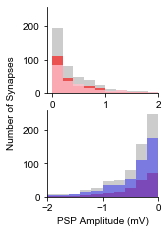

In [21]:
bin_edges = np.arange(-3, 3, 0.2)

rs_hist, ax_rs = plt.subplots(2, 1, sharey=True, sharex=False, figsize=(2, 3.5))
ex_pairs, in_pairs = ei_hist_plot(ax_rs, 'psp_amplitude', bin_edges, db, pair_query_args=pair_query_args)
ax_rs[0].set_xlim(-0.1, 2)
ax_rs[1].set_xlim(-2, 0)
ax_rs[1].set_ylabel('')
rs_hist.text(-0.15, 0.5, 'Number of Synapses', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax_rs]

In [22]:
resting_amp, units = metric_stats('psp_amplitude', db, pre_classes=ei_classes, post_classes=ei_classes, pair_query_args=pair_query_args)
print('Units: %s' % units)
resting_amp

Units: mV


count      mean       std           min       25%  \
pre_class post_class                                                      
ex        ex          224.0  0.349844  0.355356  1.059701e-02  0.100701   
          in          199.0  0.442702  0.513902  4.388342e-13  0.073334   
in        ex          190.0 -0.448912  0.464720 -3.724981e+00 -0.566358   
          in          472.0 -0.485058  0.513401 -2.966244e+00 -0.689292   

                           50%       75%       max  
pre_class post_class                                
ex        ex          0.203552  0.498112  2.175955  
          in          0.261438  0.612633  3.740153  
in        ex         -0.319138 -0.159128 -0.016844  
          in         -0.275097 -0.142681  0.000000

[None, None]

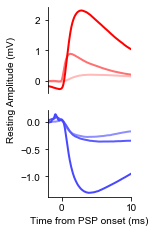

In [23]:
amp_traces, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5, 3.5))

label_e =  ['L5ET->L5ET',                    'L6pyr->pv',                  'L23pyr->sst']                      
amp_e =  [('1490642434.412', '3', '5'), ('1538165860.187', '4', '6'), ('1556746729.253', '1', '3')]
plot_metric_pairs(amp_e, 'psp_amplitude', db, ax[0], align='pulse', labels=label_e)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.xaxis.set_visible(False)

label_i = ['pv->pv',                          'pv->L4pyr',                'sst->vip']
amp_i = [('1553111233.081', '5', '2') , ('1555102684.962', '7', '6'), ('1494632512.343', '5', '4')] #('1535568208.876', '4', '8')
plot_metric_pairs(amp_i, 'psp_amplitude', db, ax[1], align='pulse', labels=label_i)
ax[1].set_xlabel('Time from PSP onset (ms)')
ax[1].set_ylabel('Resting Amplitude (mV)')

ax[1].set_ylabel('')
amp_traces.text(-0.25, 0.55, 'Resting Amplitude (mV)', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax]

### D) 90th percentile amplitude of postsynaptic responses among cell classes

Text(0.5, 0, '')

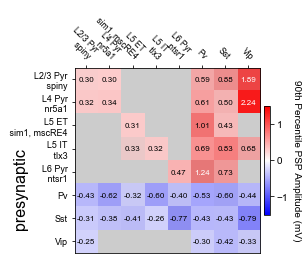

In [24]:
max_strength_fig, ax = plt.subplots(figsize=(4,4))

max_df = cell_class_matrix(cell_classes, cell_classes, 'pulse_amp_90th_percentile', class_labels, ax, db, pair_query_args=pair_query_args,
                          estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8.5)
_ = plt.setp(ax.get_yticklabels(), fontsize=9)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [25]:
max_df = max_df.astype({'pulse_amp_90th_percentile': float})
max_df.groupby(['pre_class', 'post_class']).describe()['pulse_amp_90th_percentile']

count      mean       std       min       25%       50%  \
pre_class post_class                                                            
l23pyr    l23pyr       14.0  0.000403  0.000256  0.000103  0.000288  0.000298   
          l4pyr         3.0  0.000308  0.000024  0.000287  0.000295  0.000302   
          l5et          1.0  0.000328       NaN  0.000328  0.000328  0.000328   
          pv           25.0  0.000833  0.000820  0.000253  0.000396  0.000590   
          sst          26.0  0.001407  0.001274  0.000097  0.000632  0.000880   
          vip           9.0  0.001832  0.000701  0.000428  0.001536  0.001894   
l4pyr     l23pyr        6.0  0.000381  0.000162  0.000238  0.000291  0.000319   
          l4pyr        55.0  0.000451  0.000350  0.000124  0.000241  0.000339   
          pv           14.0  0.000732  0.000444  0.000203  0.000510  0.000614   
          sst           4.0  0.000504  0.000356  0.000097  0.000287  0.000503   
          vip           2.0  0.002240  0.000162  0.002125  0.002182  0.002240   
l5et      l5et         71.0  0.000458  0.000335  0.000092  0.000219  0.000312   
          pv            4.0  0.001059  0.000416  0.000629  0.000796  0.001010   
          sst           7.0  0.000504  0.000292  0.000156  0.000283  0.000427   
l5it      l5et          5.0  0.000664  0.000678  0.000243  0.000278  0.000328   
          l5it         44.0  0.000467  0.000435  0.000080  0.000203  0.000319   
          pv           22.0  0.000759  0.000421  0.000128  0.000566  0.000693   
          sst          28.0  0.000879  0.000605  0.000106  0.000519  0.000832   
          vip           4.0  0.000836  0.000535  0.000387  0.000517  0.000680   
l6pyr     l6pyr         2.0  0.000468  0.000133  0.000374  0.000421  0.000468   
          pv            7.0  0.001231  0.000892  0.000164  0.000791  0.001237   
          sst           5.0  0.000761  0.000488  0.000379  0.000387  0.000731   
pv        l23pyr       22.0 -0.000476  0.000271 -0.001269 -0.000601 -0.000426   
          l4pyr        21.0 -0.000710  0.000464 -0.001834 -0.000879 -0.000617   
          l5et         10.0 -0.000488  0.000403 -0.001386 -0.000632 -0.000324   
          l5it         25.0 -0.000626  0.000396 -0.001835 -0.000721 -0.000598   
          l6pyr        10.0 -0.000574  0.000396 -0.001280 -0.000807 -0.000399   
          pv          233.0 -0.000650  0.000449 -0.002396 -0.000826 -0.000532   
          sst          15.0 -0.000686  0.000468 -0.002110 -0.000856 -0.000603   
          vip           7.0 -0.000481  0.000240 -0.000808 -0.000660 -0.000438   
sst       l23pyr       20.0 -0.000377  0.000193 -0.000807 -0.000482 -0.000311   
          l4pyr        14.0 -0.000481  0.000322 -0.001533 -0.000464 -0.000381   
          l5et         13.0 -0.000526  0.000417 -0.001703 -0.000514 -0.000412   
          l5it         17.0 -0.000320  0.000159 -0.000766 -0.000362 -0.000263   
          l6pyr         3.0 -0.000644  0.000357 -0.000919 -0.000846 -0.000774   
          pv           57.0 -0.000504  0.000338 -0.001754 -0.000606 -0.000431   
          sst          41.0 -0.000562  0.000411 -0.002045 -0.000604 -0.000432   
          vip          40.0 -0.000840  0.000530 -0.002490 -0.000995 -0.000794   
vip       l23pyr        2.0 -0.000254  0.000070 -0.000303 -0.000278 -0.000254   
          pv           11.0 -0.000347  0.000223 -0.000928 -0.000411 -0.000296   
          sst          29.0 -0.000524  0.000313 -0.001844 -0.000576 -0.000420   
          vip           7.0 -0.000483  0.000351 -0.001013 -0.000662 -0.000333   

                           75%       max  
pre_class post_class                      
l23pyr    l23pyr      0.000576  0.000920  
          l4pyr       0.000319  0.000335  
          l5et        0.000328  0.000328  
          pv          0.000726  0.004040  
          sst         0.001763  0.004860  
          vip         0.002232  0.002685  
l4pyr     l23pyr      0.000418  0.000681  
          l4pyr       0.000515  0.001860  
          pv          0.000

Two-sample KS test for pulse_amp_90th_percentile
Excitatory: p = 1.532e-14
Inhibitory: p = 2.193e-02


[None, None]

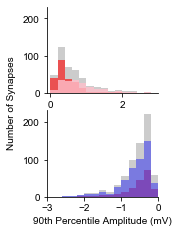

In [26]:
bin_edges = np.arange(-3, 3, 0.2)

max_hist, ax_ss = plt.subplots(2, 1, sharey=True, sharex=False, figsize=(2,3.5))
_, _ = ei_hist_plot(ax_ss, 'pulse_amp_90th_percentile', bin_edges, db, pair_query_args=pair_query_args)
ax_ss[1].set_xlabel('90th Percentile Amplitude (mV)')
ax_ss[0].set_xlim(-0.1, 3)
ax_ss[1].set_xlim(-3, 0)
ax_ss[1].set_ylabel('')
max_hist.text(-0.15, 0.5, 'Number of Synapses', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax_ss]

In [27]:
amp_90, units = metric_stats('pulse_amp_90th_percentile', db, pre_classes=ei_classes, post_classes=ei_classes, pair_query_args=pair_query_args)
print('Units: %s' % units)
amp_90

Units: mV


count      mean       std       min       25%       50%  \
pre_class post_class                                                            
ex        ex          227.0  0.482223  0.398833  0.080133  0.228441  0.338645   
          in          200.0  0.962435  0.772928  0.097204  0.462086  0.728307   
in        ex          194.0 -0.525391  0.369547 -2.091461 -0.641415 -0.419441   
          in          475.0 -0.616240  0.432696 -2.490179 -0.781041 -0.501496   

                           75%       max  
pre_class post_class                      
ex        ex          0.621764  2.660871  
          in          1.216745  4.860408  
in        ex         -0.268824 -0.064263  
          in         -0.306820 -0.038968

[None, None]

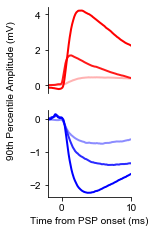

In [28]:
max_amp_traces, ax = plt.subplots(2, 1, sharex=True, figsize=(1.5, 3.5))

plot_metric_pairs(amp_e, 'pulse_amp_90th_percentile', db, ax[0], align='pulse', perc=True, labels=label_e)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.xaxis.set_visible(False)

plot_metric_pairs(amp_i, 'pulse_amp_90th_percentile', db, ax[1], align='pulse', perc=True, labels=label_i)
ax[1].set_xlabel('Time from PSP onset (ms)')
# ax[1].set_ylabel('90th Percentile Amplitude (mV)')

ax[1].set_ylabel('')
max_amp_traces.text(-0.25, 0.55, '90th Percentile Amplitude (mV)', va='center', rotation='vertical', fontsize=10)
[a.get_legend().remove() for a in ax]

#### Scatter plot

In [29]:
pair_classes = [
    ('l23pyr', 'sst'),
    ('l4pyr', 'pv'),
    ('l5et', 'l5et'),
    ('pv', 'l6pyr'),
    ('sst', 'vip'),
    ('sst', 'l5it'),
]

pair_classes = [(cell_classes[pre], cell_classes[post]) for pre, post in pair_classes]
pre_classes = {pair_class[0].name: pair_class[0] for pair_class in pair_classes}
post_classes = {pair_class[1].name: pair_class[1] for pair_class in pair_classes}

metrics = [
    'latency',
    'psp_rise_time',
    'psp_decay_tau',
    'psp_amplitude',
    'pulse_amp_90th_percentile',
]

palette = sns.color_palette('muted')
colors = [palette[5], palette[1], palette[0], palette[2], palette[6], palette[3]]

plot_args = {'alpha': 0.7, 'edgecolor': 'w'}

# for metric in metrics:
#     results, units = metric_stats(metric, db, pre_classes=pre_classes, post_classes=post_classes, pair_query_args=pair_query_args)
#     print(metric)
#     print('Units: %s' % units)
#     print(results)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


(3.830467316999564, 550)

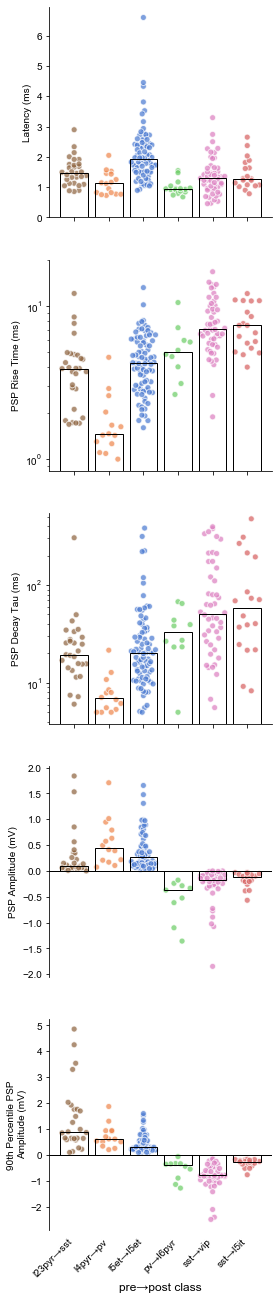

In [30]:
# import warnings; warnings.simplefilter('ignore')

swarm_fig, ax = plt.subplots(len(metrics), 1, figsize=(4, 4.5 * len(metrics)))
pair_class_metric_scatter(['latency', 'psp_rise_time'], db, pair_classes, pair_query_args, ax[0:2], palette=colors, estimator=np.median, plot_args=plot_args)
pair_class_metric_scatter(['psp_decay_tau'], db, pair_classes, decay_query_args, [ax[2]], palette=colors, estimator=np.median, plot_args=plot_args)
pair_class_metric_scatter(['psp_amplitude', 'pulse_amp_90th_percentile'], db, pair_classes, pair_query_args, ax[3:], palette=colors, estimator=np.median, plot_args=plot_args)
ax[1].tick_params(labelbottom=False)
ax[1].set_xlabel('')
ax[1].set_ylim(0, 20)
ax[2].tick_params(labelbottom=False)
ax[2].set_xlabel('')
ax[2].set_ylim(0, 550)

In [102]:
fname = os.path.join('generated_svg', 'fig3', 'Fig3_swarm.svg')
swarm_fig.savefig(fname, bbox_inches='tight')

In [33]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': latency_fig, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': latency_traces, 'pos': (310, 70), 'label': '', 'label_opts': label_opts},
    {'figure': latency_hist, 'pos': (460, 60), 'label': '', 'label_opts': label_opts},
    {'figure': rise_fig, 'pos': (0, 290), 'label': 'B', 'label_opts': label_opts},
    {'figure': rise_traces, 'pos': (310, 340), 'label': '', 'label_opts': label_opts},
    {'figure': rise_hist, 'pos': (460, 340), 'label': '', 'label_opts': label_opts},
    {'figure': decay_fig, 'pos': (0, 550), 'label': 'C', 'label_opts': label_opts},
    {'figure': decay_traces, 'pos': (310, 590), 'label': '', 'label_opts': label_opts},
    {'figure': decay_hist, 'pos': (460, 590), 'label': '', 'label_opts': label_opts},
    {'figure': resting_state_fig, 'pos': (0, 810), 'label': 'D', 'label_opts': label_opts},
    {'figure': amp_traces, 'pos': (310, 850), 'label': '', 'label_opts': label_opts},
    {'figure': rs_hist, 'pos': (460, 850), 'label': '', 'label_opts': label_opts},
    {'figure': max_strength_fig, 'pos': (0, 1070), 'label': 'E', 'label_opts': label_opts},
    {'figure': max_amp_traces, 'pos': (310, 1110), 'label': '', 'label_opts': label_opts},
    {'figure': max_hist, 'pos': (460, 1110), 'label': '', 'label_opts': label_opts},
    {'figure': swarm_fig, 'pos': (620, 65), 'label': '', 'label_opts': label_opts},
    
]

compose_svg_figure(figure_spec, size=("4.75in", "15in"), filename=os.path.join('generated_svg', 'figure_03.svg'), display=True)

Fig S12F

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  
c:\users\stephanies\appdata\local\contin

(2.0978502675776274, 243.87241247490473)

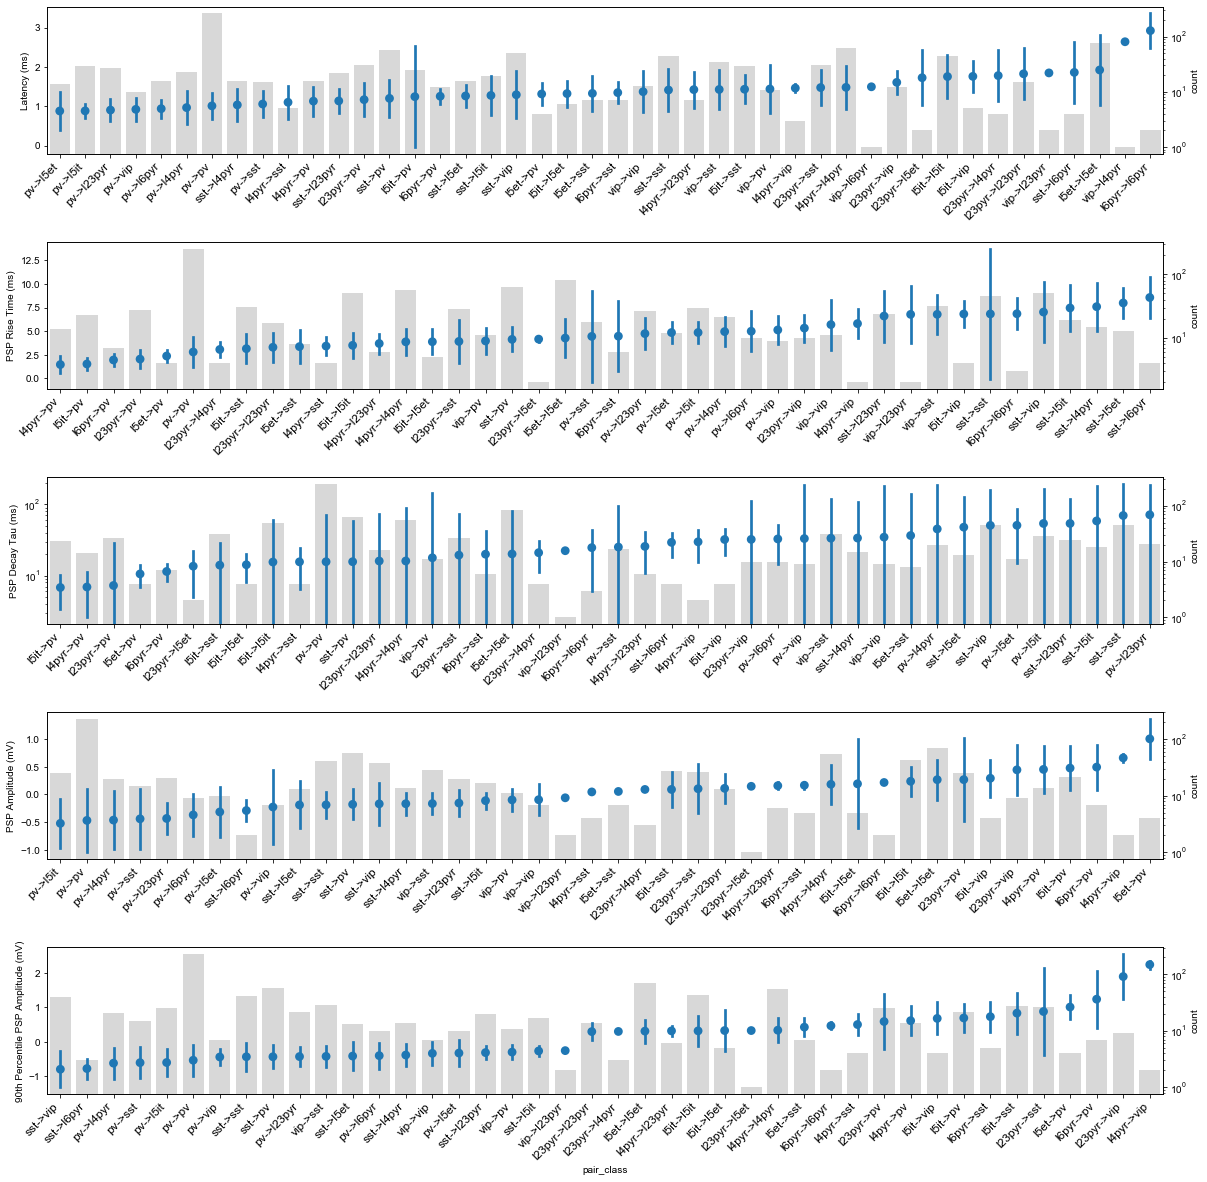

In [40]:
from aisynphys.ui.notebook import get_metric_data
def sort_metric_by_median(metric, ax, pre_classes, post_classes, pair_query_args):
    pairs_has_metric, label, units, scale, _, _, _, _, _ = get_metric_data(metric, db, pre_classes=pre_classes, post_classes=post_classes, pair_query_args=pair_query_args)
    pairs_has_metric['pair_class'] = pairs_has_metric.apply(lambda row: '%s->%s' % (row['pre_class'], row['post_class']), axis=1)
    pairs_has_metric[metric] = pd.to_numeric(pairs_has_metric[metric]*scale)
    metric_summary = pairs_has_metric.groupby('pair_class')[metric].agg({'mean': 'mean', 'median': 'median', 'std': 'std', 'count': 'count'})
    metric_summary['pair_class'] = metric_summary.index
    metric_sorted = metric_summary.sort_values('median')
    
    ax2 = ax.twinx()
    sns.barplot(x='pair_class', y='count', data=metric_summary, order=metric_sorted.index, ax=ax2, color=(0.7, 0.7, 0.7), alpha=0.5)
    plot = sns.pointplot(x='pair_class', y=metric, data=pairs_has_metric, estimator=np.median, ci='sd', join=False, order=metric_sorted.index, ax=ax)
    ax.set_ylabel('%s (%s)' % (label, units))
    ax.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    ax2.set_yscale('log')
    
  
sorted_fig, ax = plt.subplots(len(metrics), 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6)

for i, metric in enumerate(metrics):
    if metric == 'psp_decay_tau':
        sort_metric_by_median(metric, ax[i], cell_classes, cell_classes, decay_query_args)
    else:
        sort_metric_by_median(metric, ax[i], cell_classes, cell_classes, pair_query_args)
    if i != len(metrics)-1:
        ax[i].set_xlabel('')
ax[2].set_yscale('log')
ax[2].set_ylim(0)

In [41]:
fname = os.path.join('generated_svg', 'fig3', 'Fig3_sorted.svg')
sorted_fig.savefig(fname, bbox_inches='tight')